In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

## Импорт данных

In [2]:
data = pd.read_csv('data.csv', encoding= 'unicode_escape')

## Предобработка данных

In [3]:
def preprocessing(data: pd.DataFrame) -> pd.DataFrame:
    """
    Функция производит предобрвботку сырых данных:
    - удаляет:
        - заказы с нулевой ценой
        - Заказы с отсутствующим id пользователя
        - дубликаты
    - преобразует:
        - дату из строки в формат даты
    
    """
    data = data.copy()
    data = (data
            [data['UnitPrice'] != 0]
            .dropna(subset=['CustomerID'])
            .drop_duplicates())
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
    
    return data

data = preprocessing(data)

## Анализ данных

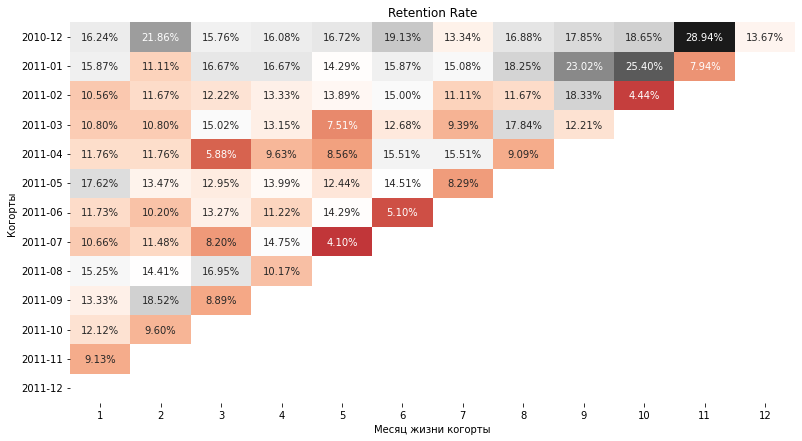

In [4]:
def get_retention_per_cohorts(data: pd.DataFrame) -> pd.DataFrame:
    """
    Расчёт Retention Rate по когортам
    Особенность: чтобы сравнение когорт было корректным, 
    учитываются только те дни каждого месяца, которые <= последнему дню последнего месяца
    """
    data = data.copy()
    data = data[data['InvoiceDate'].dt.day <= data['InvoiceDate'].max().day]
    
    data['date'] = data['InvoiceDate'].astype('datetime64[D]')
    data['first_date'] = data.groupby('CustomerID')['date'].transform(min)
    data['lifetime'] = ((data['date'] - data['first_date']) / np.timedelta64(1, 'M')).astype(int)
    data['cohort'] = data['first_date'].dt.strftime('%Y-%m')
    
    cohorts = data.pivot_table(index='cohort',
                               columns='lifetime',
                               values='CustomerID',
                               aggfunc='nunique')

    retention = cohorts.apply(
        lambda row: row / row.max(), axis=1
    ).drop(0, axis=1) 
    
    return retention
    
    
def pretty_retention(retention: pd.DataFrame):
    plt.figure(figsize=(13, 7))
    sns.heatmap(
        retention,
        annot=True,
        fmt=".2%",
        cmap='RdGy',
        cbar=False,
        vmin=0
    )
    plt.title('Retention Rate')
    plt.xlabel('Месяц жизни когорты')
    plt.ylabel('Когорты')
    plt.show()
    
pretty_retention(get_retention_per_cohorts(data))

### Вывод:
Видна сильная просадка в возвращаемости клиентов в декабре 2011, менеджеру стоит поднапречься